In [1]:
pip install pytorch-lightning  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 7.9 MB/s 
     |████████████████████████████████| 418 kB 65.4 MB/s 
     |████████████████████████████████| 140 kB 51.0 MB/s 
     |████████████████████████████████| 596 kB 54.8 MB/s 
     |████████████████████████████████| 1.1 MB 56.6 MB/s 
     |████████████████████████████████| 271 kB 67.5 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 74.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 7.8 MB/s 
     |████████████████████████████████| 308 kB 53.4 MB/s 
     |████████████████████████████████| 81 kB 11.9 MB/s 
     |████████████████████████████████| 209 kB 74.2 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 146 kB 75.6 MB/s 
     |████████████████████████████████| 112 kB 71.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ed9e379f65a6f6b28e28a39b34059fc7878862dd103d73a96cf0597d89ea4113
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss

In [6]:
from torch import distributions
from pytorch_forecasting.metrics import BaseEstimator
import torch.nn.functional as F
import optuna
import joblib

In [7]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.
    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.
        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw
        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples

    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.
        Args:
            y_pred: prediction output of network
        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps

    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood
        Args:
            y_pred: network output
            y_actual: actual values
        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss


In [8]:
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.
    Use this loss to make out of a DeepAR model a DeepVAR network.
    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric
        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )

    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
        self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)

    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

## Data


In [9]:
from pytorch_forecasting.data.encoders import GroupNormalizer
with open('/content/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [10]:
d1 = data['KRW-ZIL']
d1 = d1.sort_values('candle_date_time_kst')
d1['time_index'] = np.arange(len(d1))
date_index = d1[['time_index', 'candle_date_time_kst']]

In [11]:
res_data = pd.DataFrame()
for i, key in enumerate(data.keys()):
    tmp = data[key]
#     if tmp.shape[0] == 720:
    tmp_1 = pd.merge(tmp, date_index, on ='candle_date_time_kst')
    tmp_df_1 = tmp_1[['market', 'candle_acc_trade_volume', 'time_index', 'candle_date_time_kst', 'trade_price']]
    tmp_df_1.reset_index(inplace = True)
    try:
        res_data = pd.concat([res_data, tmp_df_1])
    except Exception as e:
        pass    

In [12]:
res_data.shape

(101553, 6)

In [13]:
gn = GroupNormalizer(
    groups= ['market'],
    scale_by_group = True
)

scaled_trade_price = gn.fit_transform(res_data['trade_price'], res_data, return_norm = True)

scaled_volume = gn.fit_transform(res_data['candle_acc_trade_volume'], res_data, return_norm = True)

res_data['trade_price'] = scaled_trade_price[0]
res_data['candle_acc_trade_volume'] = scaled_volume[0]

res_data.dropna(inplace = True)

res_data.shape

(101553, 6)

In [14]:
res_data['new_idx'] = res_data['market'] + '_' + res_data['time_index'].astype(str)
res_data.drop_duplicates(subset = ['new_idx'], inplace = True)
res_data.sort_values(['market', 'time_index'], inplace = True)
res_data.set_index('new_idx', inplace = True)

In [15]:
res_data['time_index'] = res_data['time_index'].astype(int)
res_data.reset_index(inplace = True)
res_data.drop(['new_idx'], axis = 1, inplace = True)

In [26]:
def train_model(trial): 
  cfg = {'max_encoder_length' : trial.suggest_int('max_encoder_length',10, 200, 1),
         'max_prediction_length' : trial.suggest_int('max_prediction_length',1, 20, 1),
         'batch_size' : trial.suggest_int('batch_size', 16, 1024, 4), 
         'seed' : 42, 
         'lr' : trial.suggest_loguniform('lr', 1e-4, 1e-2),
         'log_interval' : trial.suggest_int('log_interval', -10, 1000, 1),
         'log_val_interval': trial.suggest_int('log_val_interval', -10, 100, 1),
         'hidden_size' : trial.suggest_int('hidden_size', 16, 1024, 4),
         'rnn_layers' : trial.suggest_int('rnn_layers',1, 7, 1),
         'max_epochs' : trial.suggest_int('max_epochs', 10, 100, 1), 
         'limit_train_batches' : trial.suggest_int('limit_train_batches', 16, 1024, 4)} 
  
  torch.manual_seed(cfg['seed']) 
  
  max_encoder_length = cfg['max_encoder_length']
  max_prediction_length = cfg['max_prediction_length']
  training_cutoff = res_data['time_index'].max() - max_prediction_length

  context_length = max_encoder_length
  prediction_length = max_prediction_length
         
  training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index <= training_cutoff],
    time_idx = 'time_index',
    target = 'trade_price',
    categorical_encoders = {'market': NaNLabelEncoder().fit(res_data.market)},
    group_ids = ['market'],
    time_varying_unknown_reals = ['trade_price'],
    max_encoder_length = context_length,
    max_prediction_length = prediction_length,
    allow_missing_timesteps=True
  )

  validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1
  )

  train_dataloader = training.to_dataloader(train = True, batch_size = cfg['batch_size'], num_workers = 0)
  val_dataloader = validation.to_dataloader(train = False, batch_size = cfg['batch_size'], num_workers = 0)
  
  net = DeepAR.from_dataset(
    training, 
    learning_rate=cfg['lr'],
    log_interval=cfg['log_interval'],
    log_val_interval=cfg['log_val_interval'],
    hidden_size=cfg['hidden_size'],
    rnn_layers=cfg['rnn_layers'],
    loss=MultivariateNormalDistributionLoss(rank=10),
  )

  early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
  lr_logger = LearningRateMonitor()

  trainer = pl.Trainer(
    max_epochs = cfg['max_epochs'],
    gpus = 1,
    weights_summary = 'top',
    gradient_clip_val = .01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches = cfg['limit_train_batches'],
    enable_checkpointing = True,
    logger = TensorBoardLogger('./lightning_logs/deepAR')
  )

  actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
  [y[0].shape for x, y in iter(val_dataloader)]
  baseline_predictions = Baseline().predict(val_dataloader)
  smape = SMAPE()(baseline_predictions, actuals)
  print(smape)

  return MultivariateNormalDistributionLoss(rank=10)

In [27]:
sampler = optuna.samplers.TPESampler() 

study = optuna.create_study(sampler=sampler, direction='maximize') 
study.optimize(train_model, n_trials=10) 
joblib.dump(study, '/content/deepar_optuna.pkl')

[I 2022-06-02 12:31:04,751] A new study created in memory with name: no-name-eba694b1-624a-44cc-9cf2-92b99d520ad5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:05,970] Trial 0 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.2748)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:06,984] Trial 1 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.3217)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:07,952] Trial 2 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.3008)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:09,010] Trial 3 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.4053)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:10,020] Trial 4 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.5540)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:11,030] Trial 5 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.3644)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:12,040] Trial 6 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.4012)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:13,018] Trial 7 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.6786)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:14,213] Trial 8 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.2577)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[W 2022-06-02 12:31:15,273] Trial 9 failed, because the value MultivariateNormalDistributionLoss() could not be cast to float.


tensor(0.3672)


['/content/deepar_optuna.pkl']

In [28]:
study = joblib.load('/content/deepar_optuna.pkl') 
df = study.trials_dataframe() 
df.sort_values('value')

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_hidden_size,params_limit_train_batches,params_log_interval,params_log_val_interval,params_lr,params_max_encoder_length,params_max_epochs,params_max_prediction_length,params_rnn_layers,state
0,0,None,2022-06-02 12:31:04.753261,2022-06-02 12:31:05.970867,0 days 00:00:01.217606,240,880,812,846,34,0.000156,168,83,6,6,FAIL
1,1,None,2022-06-02 12:31:05.972586,2022-06-02 12:31:06.984936,0 days 00:00:01.012350,84,60,824,330,79,0.000145,196,38,5,2,FAIL
2,2,None,2022-06-02 12:31:06.986815,2022-06-02 12:31:07.952523,0 days 00:00:00.965708,568,112,52,875,17,0.002294,138,25,8,2,FAIL
3,3,None,2022-06-02 12:31:07.957293,2022-06-02 12:31:09.010884,0 days 00:00:01.053591,448,564,640,972,57,0.000308,110,28,16,4,FAIL
4,4,None,2022-06-02 12:31:09.012574,2022-06-02 12:31:10.020626,0 days 00:00:01.008052,240,404,880,859,22,0.000584,70,68,12,4,FAIL
5,5,None,2022-06-02 12:31:10.022171,2022-06-02 12:31:11.030076,0 days 00:00:01.007905,636,512,536,414,93,0.000908,90,69,10,4,FAIL
6,6,None,2022-06-02 12:31:11.031731,2022-06-02 12:31:12.040442,0 days 00:00:01.008711,240,708,88,951,33,0.000211,63,68,16,1,FAIL
7,7,None,2022-06-02 12:31:12.042049,2022-06-02 12:31:13.018367,0 days 00:00:00.976318,444,764,72,436,-7,0.001015,108,87,19,1,FAIL
8,8,None,2022-06-02 12:31:13.025485,2022-06-02 12:31:14.213050,0 days 00:00:01.187565,440,752,588,293,47,0.001852,192,61,2,6,FAIL
9,9,None,2022-06-02 12:31:14.217776,2022-06-02 12:31:15.273264,0 days 00:00:01.055488,52,108,740,362,40,0.000213,181,35,11,4,FAIL


## Calculate baseline error

In [ ]:
trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

Missing logger folder: ./lightning_logs/deepAR/lightning_logs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 0     
3 | rnn                    | LSTM                               | 5.2 K 
4 | distribution_projector | Linear                             | 252   
------------------------------------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -35.100


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.644 >= min_delta = 0.0001. New best score: -35.744


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.111 >= min_delta = 0.0001. New best score: -36.854


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.646 >= min_delta = 0.0001. New best score: -38.500


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.171 >= min_delta = 0.0001. New best score: -40.671


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.527 >= min_delta = 0.0001. New best score: -43.198


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.891 >= min_delta = 0.0001. New best score: -46.089


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.530 >= min_delta = 0.0001. New best score: -48.618


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.973 >= min_delta = 0.0001. New best score: -50.592


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.533 >= min_delta = 0.0001. New best score: -52.125


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.185 >= min_delta = 0.0001. New best score: -53.310


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.026 >= min_delta = 0.0001. New best score: -54.336


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.743 >= min_delta = 0.0001. New best score: -55.079


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.748 >= min_delta = 0.0001. New best score: -55.827


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.666 >= min_delta = 0.0001. New best score: -56.493


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.418 >= min_delta = 0.0001. New best score: -56.911


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.525 >= min_delta = 0.0001. New best score: -57.437


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.574 >= min_delta = 0.0001. New best score: -58.011


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.742 >= min_delta = 0.0001. New best score: -58.752


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.653 >= min_delta = 0.0001. New best score: -59.406


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.664 >= min_delta = 0.0001. New best score: -60.070


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.426 >= min_delta = 0.0001. New best score: -60.496


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.386 >= min_delta = 0.0001. New best score: -60.882


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.427 >= min_delta = 0.0001. New best score: -61.309


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.438 >= min_delta = 0.0001. New best score: -61.747


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.332 >= min_delta = 0.0001. New best score: -62.078


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.304 >= min_delta = 0.0001. New best score: -62.382


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.505 >= min_delta = 0.0001. New best score: -62.887


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.189 >= min_delta = 0.0001. New best score: -63.076


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.762 >= min_delta = 0.0001. New best score: -63.837


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.343 >= min_delta = 0.0001. New best score: -64.180


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.228 >= min_delta = 0.0001. New best score: -64.409


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.865 >= min_delta = 0.0001. New best score: -65.273


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.632 >= min_delta = 0.0001. New best score: -65.905


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.768 >= min_delta = 0.0001. New best score: -66.673


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.742 >= min_delta = 0.0001. New best score: -67.415


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.679 >= min_delta = 0.0001. New best score: -68.095


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.036 >= min_delta = 0.0001. New best score: -69.131


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.486 >= min_delta = 0.0001. New best score: -69.617


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.790 >= min_delta = 0.0001. New best score: -70.406


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.894 >= min_delta = 0.0001. New best score: -71.300


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.348 >= min_delta = 0.0001. New best score: -71.648


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.621 >= min_delta = 0.0001. New best score: -72.270


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.128 >= min_delta = 0.0001. New best score: -72.397


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.851 >= min_delta = 0.0001. New best score: -73.249


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.721 >= min_delta = 0.0001. New best score: -73.969


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.144 >= min_delta = 0.0001. New best score: -74.114


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.693 >= min_delta = 0.0001. New best score: -74.807


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.122 >= min_delta = 0.0001. New best score: -74.929


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.583 >= min_delta = 0.0001. New best score: -75.512


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0001. New best score: -75.550


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.179 >= min_delta = 0.0001. New best score: -75.730


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.977 >= min_delta = 0.0001. New best score: -76.707


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.315 >= min_delta = 0.0001. New best score: -77.022


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: -77.022. Signaling Trainer to stop.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.1580)

In [ ]:
predictions, _ = best_model.predict(val_dataloader, return_x=True, n_samples=100)
predictions.shape

torch.Size([192, 10])

In [ ]:
actuals.shape

torch.Size([192, 10])

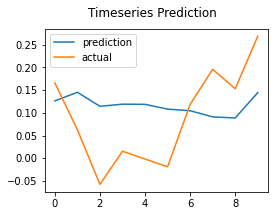

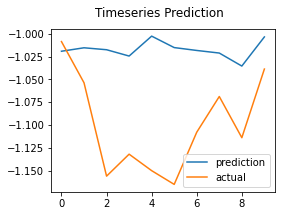

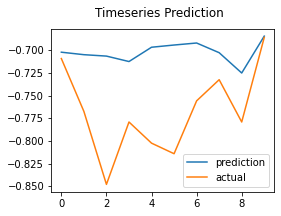

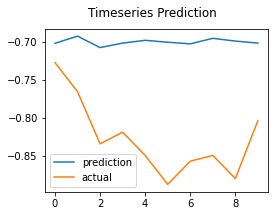

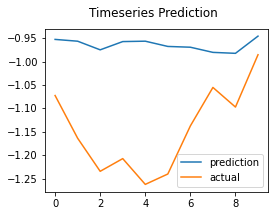

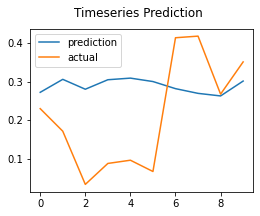

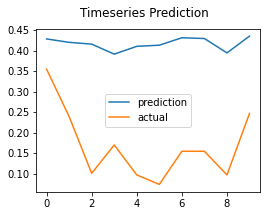

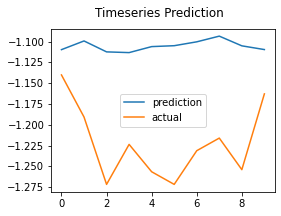

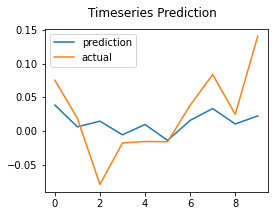

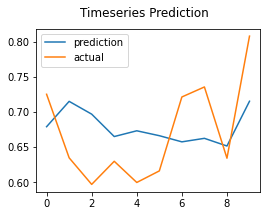

In [ ]:
for i in np.arange(100, 110):
    plt.figure(figsize=(4, 3))
    plt.plot(predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()